#  Customer Segmentation using RFM Analysis


RFM Analysis evaluates customers based on:
- **Recency (R)** – Days since the last purchase  
- **Frequency (F)** – Total number of purchases  
- **Monetary (M)** – Total spend  

We use these metrics to create customer segments for targeted marketing.


In [1]:
import pandas as pd
from datetime import datetime as dt, timedelta
import matplotlib.pyplot as plt
import seaborn as sns


In [2]:
#Importing the dataset

df = pd.read_excel('OnlineRetail.xlsx')

In [3]:
df.head()


,InvoiceNo,StockCode,Description,Quantity,InvoiceDate,UnitPrice,CustomerID,Country
0,536365,85123A,WHITE HANGING HEART T-LIGHT HOLDER,6,2010-12-01 08:26:00,2.55,17850.0,United Kingdom
1,536365,71053,WHITE METAL LANTERN,6,2010-12-01 08:26:00,3.39,17850.0,United Kingdom
2,536365,84406B,CREAM CUPID HEARTS COAT HANGER,8,2010-12-01 08:26:00,2.75,17850.0,United Kingdom
3,536365,84029G,KNITTED UNION FLAG HOT WATER BOTTLE,6,2010-12-01 08:26:00,3.39,17850.0,United Kingdom
4,536365,84029E,RED WOOLLY HOTTIE WHITE HEART.,6,2010-12-01 08:26:00,3.39,17850.0,United Kingdom


In [4]:
#Checking for null values
df.isnull().sum()

InvoiceNo           0
StockCode           0
Description      1454
Quantity            0
InvoiceDate         0
UnitPrice           0
CustomerID     135080
Country             0
dtype: int64

In [6]:
#As we see there are a lot of missing values in CustomerID we will drop the null values

df.dropna(subset= ['CustomerID'] , inplace= True)

In [7]:
df.isnull().sum()

InvoiceNo      0
StockCode      0
Description    0
Quantity       0
InvoiceDate    0
UnitPrice      0
CustomerID     0
Country        0
dtype: int64

In [8]:
#Converting InvoiceDate into datetime format

df['InvoiceDate'] = pd.to_datetime(df['InvoiceDate'])
#Calculating total amount

df['TotalAmount'] = df['Quantity'] * df['UnitPrice']

In [9]:
df.head()

,InvoiceNo,StockCode,Description,Quantity,InvoiceDate,UnitPrice,CustomerID,Country,TotalAmount
0,536365,85123A,WHITE HANGING HEART T-LIGHT HOLDER,6,2010-12-01 08:26:00,2.55,17850.0,United Kingdom,15.30
1,536365,71053,WHITE METAL LANTERN,6,2010-12-01 08:26:00,3.39,17850.0,United Kingdom,20.34
2,536365,84406B,CREAM CUPID HEARTS COAT HANGER,8,2010-12-01 08:26:00,2.75,17850.0,United Kingdom,22.00
3,536365,84029G,KNITTED UNION FLAG HOT WATER BOTTLE,6,2010-12-01 08:26:00,3.39,17850.0,United Kingdom,20.34
4,536365,84029E,RED WOOLLY HOTTIE WHITE HEART.,6,2010-12-01 08:26:00,3.39,17850.0,United Kingdom,20.34


In [10]:
#setting refrence date 
reference_date = df['InvoiceDate'].max() + timedelta(days= 1)

In [12]:
#Now lets take the steps to calucalte RFM but first lets groupby

rfm = df.groupby('CustomerID').agg({
    'InvoiceDate': lambda x: (reference_date - x.max()).days,
    'InvoiceNo' : 'nunique',
    'TotalAmount': 'sum'
})

In [13]:
rfm.head()

,InvoiceDate,InvoiceNo,TotalAmount
CustomerID,,,
12346.0,326,2,0.00
12347.0,2,7,4310.00
12348.0,75,4,1797.24
12349.0,19,1,1757.55
12350.0,310,1,334.40


In [17]:
#Now We will rename columns for better understanding 

rfm.rename(columns={
    'InvoiceDate': 'Recency',
    'InvoiceNo': 'Frequencey',
    'TotalAmount': 'Monetary'
}, inplace= True)


In [18]:
rfm.head(1)

,Recency,Frequencey,Monetary
CustomerID,,,
12346.0,326,2,0.0


In [20]:
#now lets assign scores to these customers based on RFM
rfm['R'] = pd.qcut(rfm['Recency'], 5, labels=[5,4,3,2,1])

rfm['F'] = pd.qcut(rfm['Frequencey'].rank(method='first'), 5, labels=[1,2,3,4,5])

rfm['M'] = pd.qcut(rfm['Monetary'], 5, labels=[1,2,3,4,5])

In [21]:
rfm.head(1)

,Recency,Frequencey,Monetary,R,F,M
CustomerID,,,,,,
12346.0,326,2,0.0,1,2,1


In [22]:
#Segment the Customers based on their scores
def segment_customer(row):
    if row['R'] >= 4 and row['F'] >= 4:
        return 'Champions'
    elif row['R'] >= 3 and row['F'] >= 3:
        return 'Loyal Customers'
    elif row['M'] >= 4:
        return 'Big Spenders'
    elif row['R'] <= 2 and row['F'] >= 3:
        return 'At Risk'
    else:
        return 'Others'
rfm['Segment'] = rfm.apply(segment_customer, axis = 1)

- Champions: High spenders who buy frequently and recently.

- Loyal Customers: Frequent buyers but not as recent.

- At Risk: Used to buy often, but haven’t purchased recently.

- Others: Low scores in recency and frequency.

In [23]:
rfm.head(2)

,Recency,Frequencey,Monetary,R,F,M,Segment
CustomerID,,,,,,,
12346.0,326,2,0.0,1,2,1,Others
12347.0,2,7,4310.0,5,4,5,Champions


In [25]:
rfm['RFM_Score'] = (
    rfm['R'].astype(str) +
    rfm['F'].astype(str) +
    rfm['M'].astype(str)
)


C:\Users\Haris\AppData\Local\Temp\ipykernel_10960\3013199217.py:6: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `x` variable to `hue` and set `legend=False` for the same effect.

  sns.countplot(data=rfm, x='Segment', order=rfm['Segment'].value_counts().index, palette='viridis')


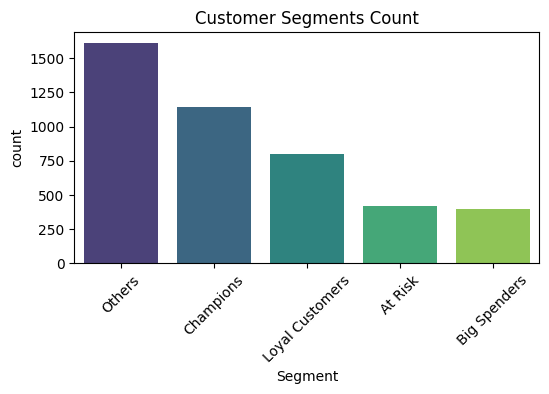

In [31]:
#plotting the findings 

rfm['Segment'].value_counts()

plt.figure(figsize=(6, 3))
sns.countplot(data=rfm, x='Segment', order=rfm['Segment'].value_counts().index, palette='viridis')
plt.xticks(rotation=45)
plt.title("Customer Segments Count")
plt.show()

C:\Users\Haris\AppData\Local\Temp\ipykernel_10960\1361652179.py:1: FutureWarning: The default value of observed=False is deprecated and will change to observed=True in a future version of pandas. Specify observed=False to silence this warning and retain the current behavior
  rfm_pivot = rfm.pivot_table(


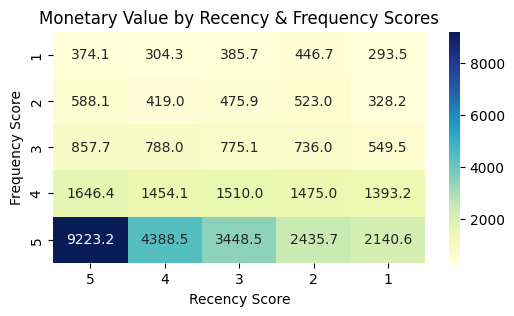

In [33]:
rfm_pivot = rfm.pivot_table(
    index='F', 
    columns='R', 
    values='Monetary', 
    aggfunc='mean'
)
plt.figure(figsize=(6,3))
sns.heatmap(
    rfm_pivot, 
    annot=True, 
    fmt=".1f", 
    cmap="YlGnBu"
)
plt.title('Monetary Value by Recency & Frequency Scores')
plt.ylabel('Frequency Score')
plt.xlabel('Recency Score')
plt.show()

### Conclusion

Most customers fall under "Others", showing potential for engagement. Champions, Loyal Customers, and Big Spenders are key revenue drivers and should be nurtured. At Risk customers need reactivation efforts.

The heatmap shows that high recency and frequency lead to the highest spending, while low scores contribute little, stressing the need for regular engagement to boost revenue.